## Experiment DL learning with custom embedding and simple Dense layer
Even if the training set is too small to produce a representative word embedding, this notebook illustrates an experiment to have a rough idea on the resulting score with such embedding choice

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')
XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)

In [3]:
# hyper params
num_classes = 51
patience=20
vocabulary_size = 10000
sequence_length = 30
hidden_dims = 200
embedding_out_dims = 300
dropout_rate=0.2
num_epochs= 100

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build the neural network
The NN is composed of 3 layers:
* custom embeddding layer
* fully connected layer to learn classification with relu activation
* decision layer with sotfmax activation

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

import tensorflow as tf
#config = tf.ConfigProto(device_count={"CPU": 32})
config = tf.ConfigProto()
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

model = Sequential()
model.add(Embedding(vocabulary_size , embedding_out_dims, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1800200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                10251     
Total params: 4,810,451
Trainable params: 4,810,451
Non-trainable params: 0
_________________________________________________________________


### Train the network

In [6]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [7]:
import keras.utils

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

model.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.1,
    epochs=num_epochs,
    callbacks = [call_back_early_stopping])

Train on 6140 samples, validate on 683 samples
Epoch 1/100
6140/6140 [==============================] - 3s 553us/step - loss: 2.9335 - acc: 0.2837 - val_loss: 2.5218 - val_acc: 0.3777
Epoch 2/100
6140/6140 [==============================] - 2s 379us/step - loss: 1.7384 - acc: 0.5761 - val_loss: 1.8886 - val_acc: 0.5242
Epoch 3/100
6140/6140 [==============================] - 2s 380us/step - loss: 0.7164 - acc: 0.8293 - val_loss: 1.7542 - val_acc: 0.5666
Epoch 4/100
6140/6140 [==============================] - 2s 380us/step - loss: 0.2648 - acc: 0.9446 - val_loss: 1.7988 - val_acc: 0.5827
Epoch 5/100
6140/6140 [==============================] - 2s 377us/step - loss: 0.1229 - acc: 0.9769 - val_loss: 1.9000 - val_acc: 0.5915
Epoch 6/100
6140/6140 [==============================] - 2s 383us/step - loss: 0.0734 - acc: 0.9863 - val_loss: 1.9641 - val_acc: 0.5827
Epoch 7/100
6140/6140 [==============================] - 2s 383us/step - loss: 0.0538 - acc: 0.9883 - val_loss: 1.9922 - val_acc: 0

In [11]:
# %load "../utils/vizu.py"
import matplotlib.pyplot as plt
import itertools

def plot_keras_model_learning_curve(history):
    ''' plot accuracy of the Keras model on training and validation set '''
    plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

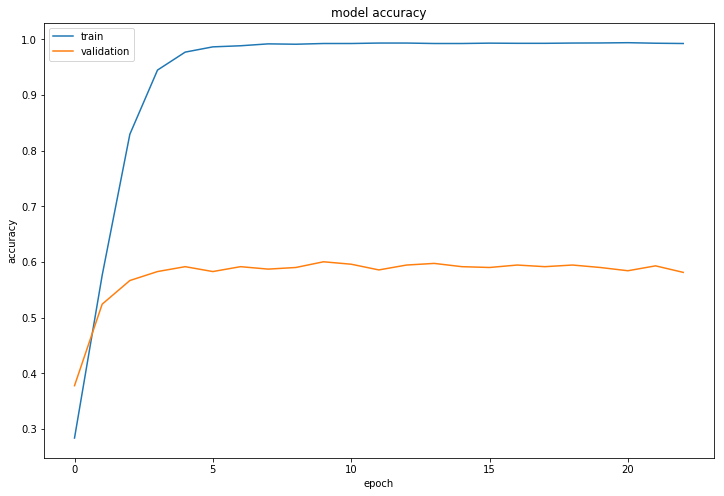

In [12]:
%matplotlib inline

plot_keras_model_learning_curve(model.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.94      0.46      0.62        35
          1       0.00      0.00      0.00         4
          2       1.00      0.20      0.33         5
          3       0.00      0.00      0.00         1
          4       0.67      0.73      0.70        11
          5       0.55      0.33      0.41        18
          6       1.00      0.75      0.86         4
          7       0.00      0.00      0.00         1
          8       0.73      0.64      0.68        25
          9       0.50      0.29      0.36         7
         10       0.45      0.42      0.43        12
         11       0.41      0.33      0.37        27
         12       0.13      0.33      0.19         6
         13       0.21      0.25      0.23        12
         14       0.33      0.36      0.34        42
         15       0.50      0.25      0.33         4
         16       0.67      0.67      0.67         3
         17       0.50      0.50      0.50   

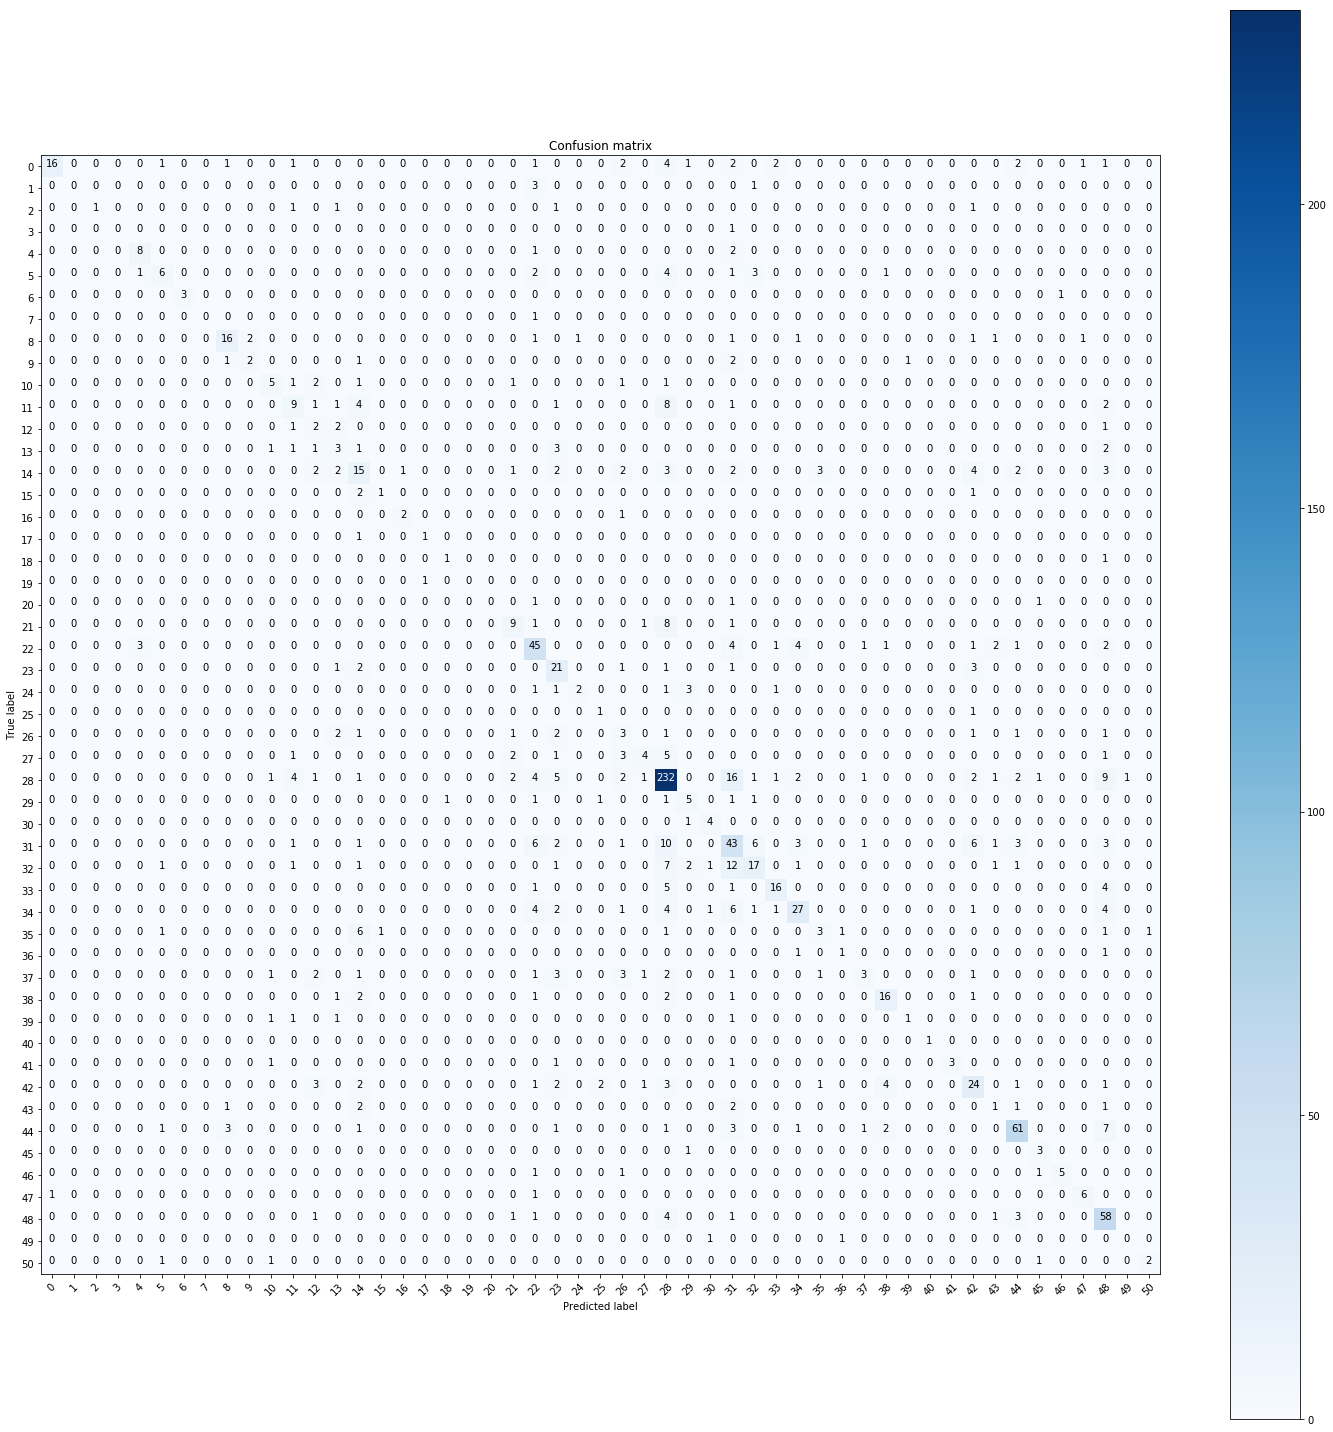

In [13]:
import sklearn
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


The model is overfitting rapidly beyond 5 epochs but no observed accuracy improvement on validation set (get rapidly stationary accuracy aounrd 62%)